# Machine Learning 

work by:
- Inês Castro

- Simão Gomes

- Soraia Costa

# Data Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    GlobalAveragePooling2D,
    Dense,
    Dropout
)
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)


In [2]:

# 1. Load metadata
metadata_path = "./UrbanSound8K/metadata/UrbanSound8K.csv"
meta_df = pd.read_csv(metadata_path)

print("Metadata loaded with shape:", meta_df.shape)
meta_df.head()


Metadata loaded with shape: (8732, 8)


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
print("\nColumns:")
print(meta_df.columns)

print("\nBasic statistics:")
meta_df.describe(include='all')



Columns:
Index(['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold',
       'classID', 'class'],
      dtype='object')

Basic statistics:


,slice_file_name,fsID,start,end,salience,fold,classID,class
count,8732,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732
unique,8732,NaN,NaN,NaN,NaN,NaN,NaN,10
top,100032-3-0-0.wav,NaN,NaN,NaN,NaN,NaN,NaN,dog_bark
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,1000
mean,NaN,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877,NaN
std,NaN,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544,NaN
min,NaN,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000,NaN
25%,NaN,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000,NaN
50%,NaN,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000,NaN
75%,NaN,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000,NaN


Class distribution

Let’s check how many samples there are for each sound class.

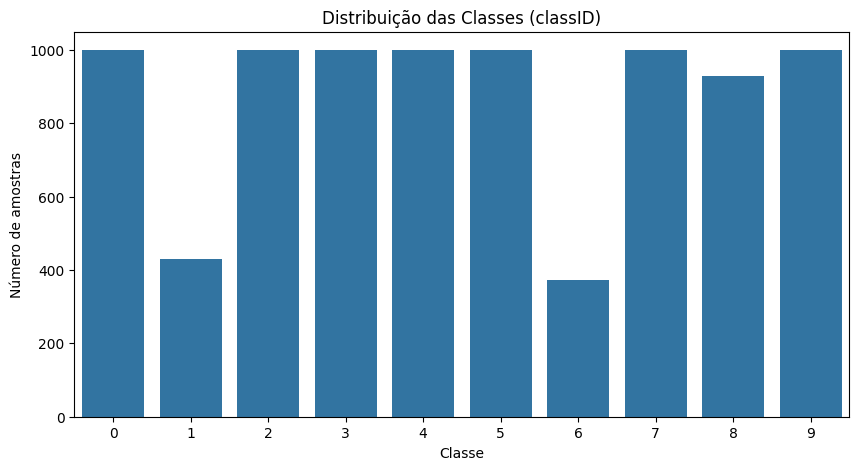


Samples per class:
class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: class, dtype: int64


In [4]:
plt.figure(figsize=(10,5))
sns.countplot(data=meta_df, x="classID", order=sorted(meta_df["classID"].unique()))
plt.title("Distribuição das Classes (classID)")
plt.xlabel("Classe")
plt.ylabel("Número de amostras")
plt.show()

# Mapeamento nome -> ID
class_counts = meta_df.groupby("class")["class"].count()
print("\nSamples per class:")
print(class_counts)


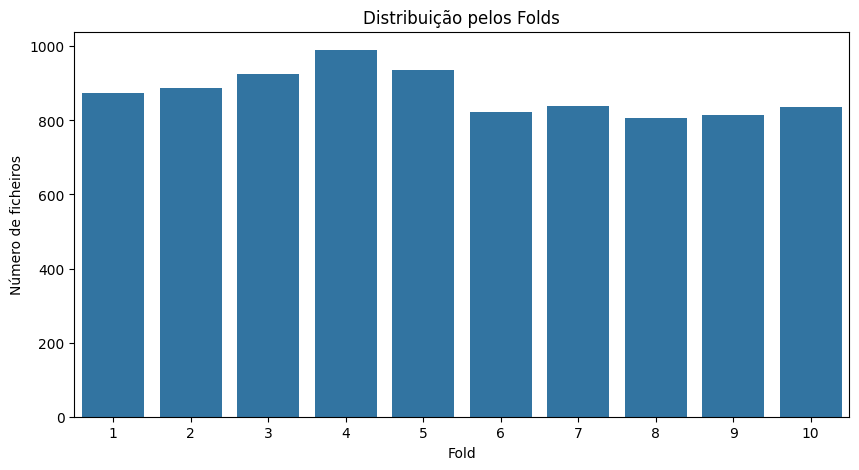


Samples per fold:
fold
1     873
2     888
3     925
4     990
5     936
6     823
7     838
8     806
9     816
10    837
Name: count, dtype: int64


In [5]:
plt.figure(figsize=(10,5))
sns.countplot(data=meta_df, x="fold", order=sorted(meta_df["fold"].unique()))
plt.title("Distribuição pelos Folds")
plt.xlabel("Fold")
plt.ylabel("Número de ficheiros")
plt.show()

fold_counts = meta_df["fold"].value_counts().sort_index()
print("\nSamples per fold:")
print(fold_counts)


Analyze clip durations

We’ll calculate and visualize how long each audio clip is.

1 create a column named duration

In [6]:
meta_df["duration"] = meta_df["end"] - meta_df["start"]

meta_df[["slice_file_name", "start", "end", "duration"]].head()


,slice_file_name,start,end,duration
0,100032-3-0-0.wav,0.0,0.317551,0.317551
1,100263-2-0-117.wav,58.5,62.500000,4.000000
2,100263-2-0-121.wav,60.5,64.500000,4.000000
3,100263-2-0-126.wav,63.0,67.000000,4.000000
4,100263-2-0-137.wav,68.5,72.500000,4.000000


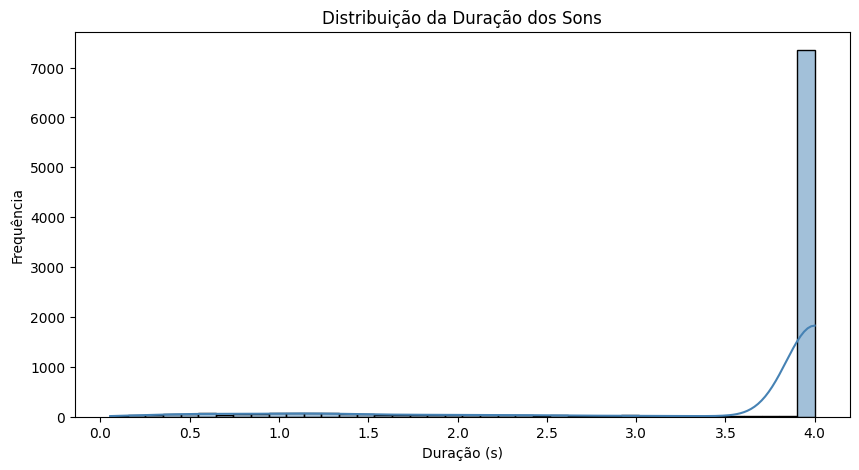

In [7]:
plt.figure(figsize=(10,5))

# Histograma
sns.histplot(meta_df["duration"], bins=40, kde=True, color="steelblue")

plt.title("Distribuição da Duração dos Sons")
plt.xlabel("Duração (s)")
plt.ylabel("Frequência")
plt.show()


Depois de analisarmos características globais dos áudios, como a sua duração, torna-se essencial compreender quais atributos do som são realmente informativos para um modelo de deep learning. Sons não são apenas ondas ao longo do tempo: possuem padrões de energia, frequências dominantes, variações harmónicas e estruturas temporais que permitem distinguir um “dog bark” de um “car horn”.

Assim, nesta secção passamos da análise descritiva dos ficheiros para a exploração das features acústicas mais comuns na classificação de áudio, preparando terreno para a extração de MFCCs, mel spectrograms e outras representações fundamentais.

Código: Extrair atributos básicos de um som

Vamos escolher um ficheiro do dataset.

In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

# Escolher um exemplo qualquer da metadata
example = meta_df.iloc[0]
fold = example["fold"]
filename = example["slice_file_name"]

audio_path = f"./UrbanSound8K/audio/fold{fold}/{filename}"

y, sr = librosa.load(audio_path, sr=None)
print("Sample rate:", sr)
print("Signal length:", len(y))


Sample rate: 44100
Signal length: 14004


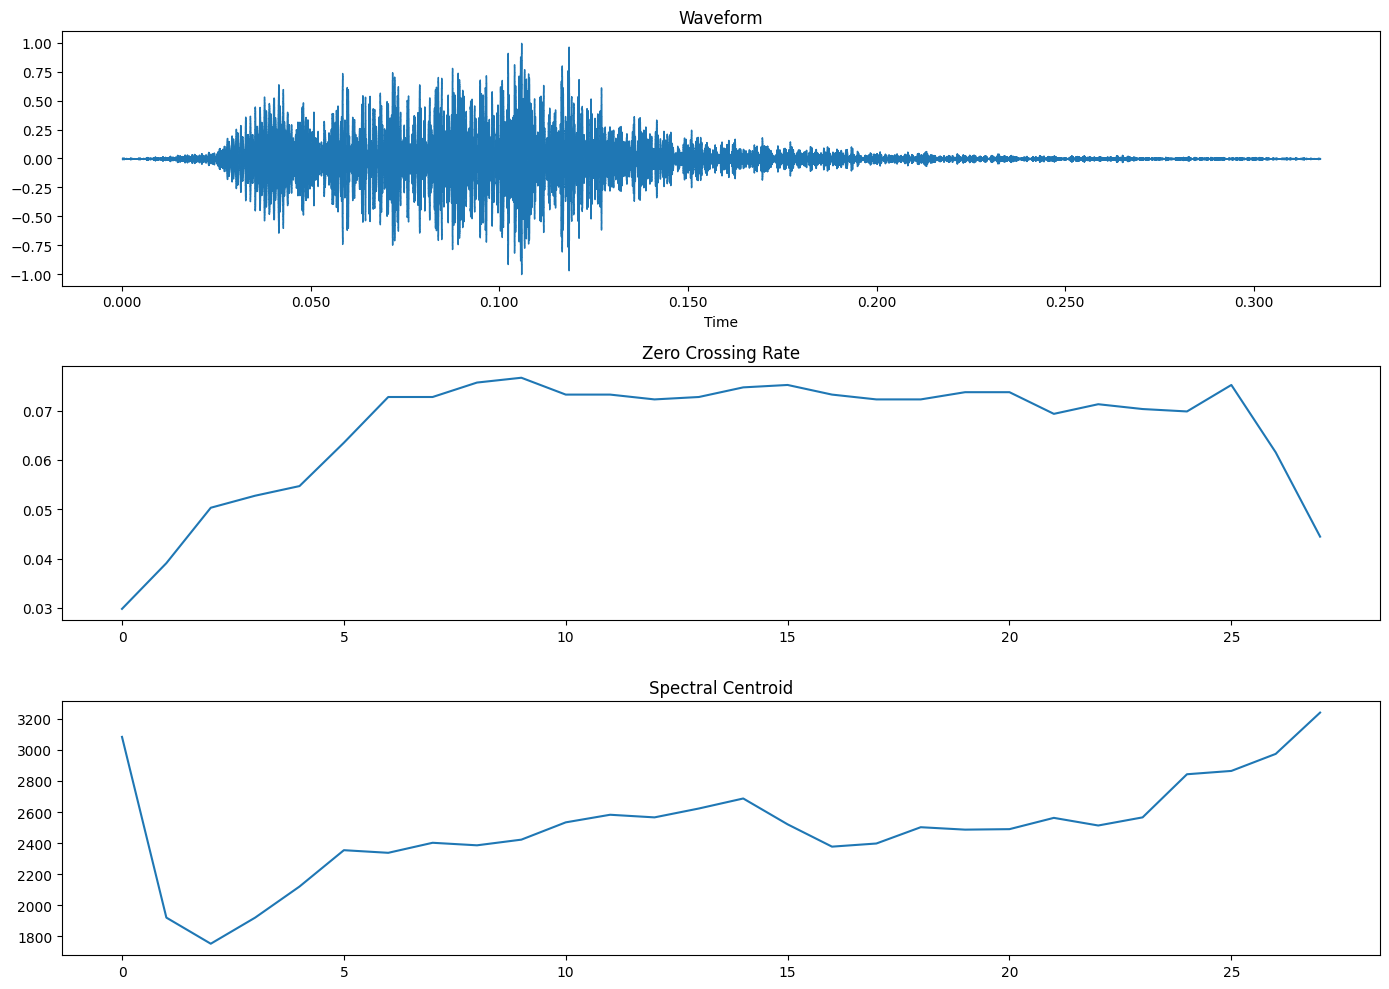

In [9]:
plt.figure(figsize=(14, 10))

# 1. Waveform
plt.subplot(3,1,1)
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.tight_layout()

# 2. Zero Crossing Rate
zcr = librosa.feature.zero_crossing_rate(y)[0]
plt.subplot(3,1,2)
plt.plot(zcr)
plt.title("Zero Crossing Rate")
plt.tight_layout()

# 3. Spectral Centroid
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
plt.subplot(3,1,3)
plt.plot(centroid)
plt.title("Spectral Centroid")
plt.tight_layout()

plt.show()


A forma de onda revela um ataque inicial repentino, típico de sons impulsivos. O Zero Crossing Rate elevado indica grande densidade de transições no sinal, refletindo ruído e riqueza de frequências altas. O Spectral Centroid confirma esta leitura, mantendo-se em valores elevados ao longo do áudio. Em conjunto, estas métricas sugerem que o som pertence a classes de impacto ou maquinaria, como drilling ou jackhammer.

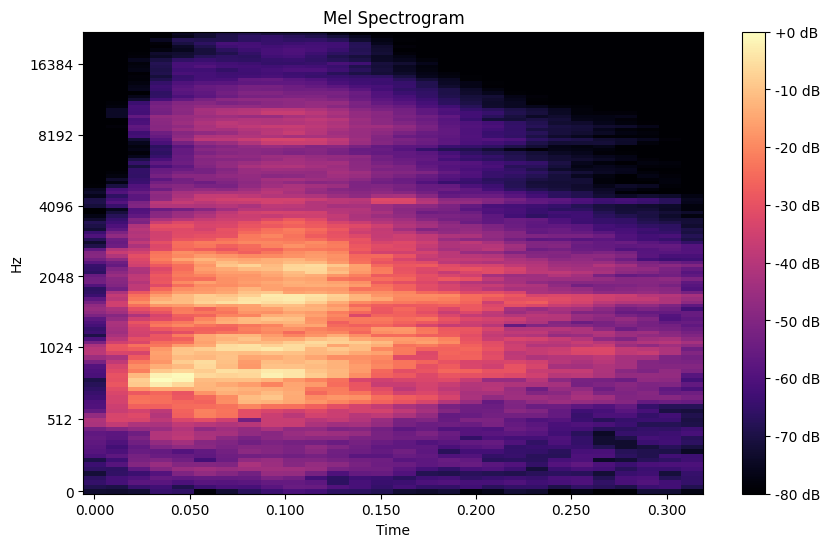

In [10]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10,6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.title("Mel Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.show()


O Mel Spectrogram revela um som de curta duração com um ataque inicial extremamente energético, distribuído por um largo espectro de frequências. A energia concentra-se sobretudo entre 1–3 kHz, faixa típica de sons urbanos mecânicos, enquanto componentes acima de 4 kHz surgem apenas no instante inicial, sugerindo um impacto ou vibração metálica.

In [11]:
from IPython.display import Audio

Audio(audio_path)


# Data pre-processing and preparation
 

### Pré-processamento dos dados

Antes da extração de características e da construção dos modelos, foi realizado um pré-processamento inicial de forma a garantir que todos os ficheiros áudio do dataset apresentavam um formato uniforme e compatível com as redes neuronais utilizadas. Este procedimento incluiu três etapas fundamentais:

1. Normalização da duração

Todos os ficheiros foram carregados e ajustados para uma duração fixa de 4,0 segundos.

Quando o áudio original excedia este valor, era truncado.

Quando apresentava uma duração inferior, aplicava-se padding espelhado (reflect padding), distribuído simetricamente no início e no fim do sinal.
Esta abordagem garante que todos os exemplos têm exatamente o mesmo número de amostras, preservando simultaneamente a continuidade local do sinal.

2. Unificação da taxa de amostragem

Todos os ficheiros foram convertidos para uma taxa de amostragem única de 22 050 Hz, através do librosa.load.
Esta uniformização é essencial para que diferentes gravações apresentem a mesma resolução temporal e para que os métodos de extração de características produzam tensores com dimensões consistentes.

3. Escalonamento da amplitude

O carregamento dos ficheiros com librosa.load (modo float32) normaliza automaticamente os valores de amplitude do áudio para o intervalo aproximado [-1, 1], independentemente do formato original (ex.: 16-bit PCM).
O padding aplicado mantém este intervalo, uma vez que apenas replica valores existentes.
Assim, todos os sinais de áudio partilham a mesma escala de amplitude, o que contribui para estabilidade numérica durante o treino das redes neuronais.

De forma geral, este pré-processamento inicial assegura que todos os exemplos do dataset apresentam duração fixa, taxa de amostragem comum e amplitudes normalizadas, estabelecendo uma base sólida para a extração de características subsequente (waveform 1D, mel-spectrogramas e MFCCs) e para o treino consistente dos modelos neuronais.

In [12]:
from pathlib import Path
import pandas as pd
import numpy as np
import librosa

# Caminho base: notebook está na pasta "trabalho"
DATASET_PATH = Path("UrbanSound8K")

# Subpastas
AUDIO_DIR = DATASET_PATH / "audio"
METADATA_PATH = DATASET_PATH / "metadata" / "UrbanSound8K.csv"

# Verificar se o caminho existe
print("Áudio existe:", AUDIO_DIR.exists())
print("Metadata existe:", METADATA_PATH.exists())

# Carregar CSV
metadata = pd.read_csv(METADATA_PATH)
metadata.head()

# Parâmetros globais
SAMPLE_RATE = 12000
DURATION = 4.0
SAMPLES_PER_TRACK = int(SAMPLE_RATE * DURATION)
N_MFCC = 13


Áudio existe: True
Metadata existe: True


### Função com padding espelhado (simétrico)

In [13]:
def load_and_pad_mirror(file_path, sr=SAMPLE_RATE, target_len=SAMPLES_PER_TRACK):
    y, _ = librosa.load(file_path, sr=sr, mono=True)

    if len(y) > target_len:
        y = y[:target_len]

    elif len(y) < target_len:
        diff = target_len - len(y)
        pad_left = diff // 2
        pad_right = diff - pad_left
        y = np.pad(y, (pad_left, pad_right), mode='reflect')

    return y, sr


| Duração do áudio | Ação no pré-processamento                  |
|------------------|--------------------------------------------|
| > 4.0 s          | Corta para 4.0 s exatos                    |
| < 4.0 s          | Adiciona padding espelhado até 4.0 s       |
| = 4.0 s          | Não faz nada — já está perfeito             |


### Feature Engineering – CNN 1D (waveform)

In [14]:
def extract_waveform(signal):
    return signal  # já está com duração fixa


### Feature Engineering – CNN 2D (Mel-Spectrogram)

In [15]:
def extract_mel_spectrogram(signal, sr=SAMPLE_RATE, n_mels=128, hop_length=512):
    mel = librosa.feature.melspectrogram(
        y=signal,
        sr=sr,
        n_mels=n_mels,
        hop_length=hop_length
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db.T   # formato (T, n_mels)


### Feature Engineering – CNN 2D (MFCC)

In [16]:
def extract_mfcc(signal, sr=SAMPLE_RATE, n_mfcc=N_MFCC, hop_length=512):
    mfcc = librosa.feature.mfcc(
        y=signal,
        sr=sr,
        n_mfcc=n_mfcc,
        hop_length=hop_length
    )
    return mfcc.T    # formato (T, n_mfcc)


### Padronizar comprimento das features 2D (Mel/MFCC)

CNN 2D precisa de input quadrado/retangular com o mesmo tempo T.

In [17]:
def pad_features(X_list):
    max_len = max([f.shape[0] for f in X_list])
    X_padded = [np.pad(f, ((0, max_len - f.shape[0]), (0, 0))) for f in X_list]
    return np.stack(X_padded)


### Função universal de dataset builder

In [18]:
def build_dataset(metadata, mode="mfcc"):
    X, y_labels = [], []

    for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
        try:
            path = AUDIO_DIR / f"fold{row.fold}" / row.slice_file_name

            signal, sr = load_and_pad_mirror(path)

            if mode == "wave":
                feat = extract_waveform(signal)

            elif mode == "mel":
                feat = extract_mel_spectrogram(signal, sr)

            elif mode == "mfcc":
                feat = extract_mfcc(signal, sr)

            X.append(feat)
            y_labels.append(row.classID)

        except Exception as e:
            print(f"Erro no ficheiro {row.slice_file_name}: {e}")

    return X, np.array(y_labels)


### Construir os 3 datasets

#### CNN 1D (Waveform)

In [19]:
X_wave, y_wave = build_dataset(metadata, mode="wave")
X_wave = np.stack(X_wave)
X_wave = X_wave[..., np.newaxis]  # (N, samples, 1)

100%|██████████| 8732/8732 [05:25<00:00, 26.86it/s]


#### CNN 2D (Mel-Spectrogram)

In [20]:
X_mel, y_mel = build_dataset(metadata, mode="mel")
X_mel = pad_features(X_mel)
X_mel = X_mel[..., np.newaxis]  # (N, T, mel_bins, 1)


100%|██████████| 8732/8732 [04:41<00:00, 31.05it/s]


### CNN 2D (MFCC)

In [21]:
X_mfcc, y_mfcc = build_dataset(metadata, mode="mfcc")
X_mfcc = pad_features(X_mfcc)
X_mfcc = X_mfcc[..., np.newaxis]  # (N, T, n_mfcc, 1)


100%|██████████| 8732/8732 [05:09<00:00, 28.18it/s]


### Guardar os datasets (opcional)

In [22]:
np.save("X_wave.npy", X_wave)
np.save("y_wave.npy", y_wave)

np.save("X_mel.npy", X_mel)
np.save("y_mel.npy", y_mel)

np.save("X_mfcc.npy", X_mfcc)
np.save("y_mfcc.npy", y_mfcc)


# Arquiteturas dos modelos

### 1.1 CNN 1D – waveform

In [23]:
def build_cnn1d_wave(input_shape, num_classes=10):
    model = models.Sequential()
    
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv1D(16, kernel_size=9, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=4))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv1D(32, kernel_size=9, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=4))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv1D(64, kernel_size=9, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=4))
    model.add(layers.Dropout(0.3))
    
    # Em vez de Flatten gigante → GlobalAveragePooling
    model.add(layers.GlobalAveragePooling1D())
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [37]:
# ------------------------------------------------------------
# 1. Selecionar folds
# ------------------------------------------------------------
fold_train = 1
fold_val   = 2
fold_test  = 3

mask_train = (metadata["fold"] == fold_train).values
mask_val   = (metadata["fold"] == fold_val).values
mask_test  = (metadata["fold"] == fold_test).values

X_train = X_wave[mask_train]
y_train = y_wave[mask_train]

X_val = X_wave[mask_val]
y_val = y_wave[mask_val]

X_test = X_wave[mask_test]
y_test = y_wave[mask_test]

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

history = model_cnn1d.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

model_cnn1d.save(final_model_path)

print("A avaliar no TESTE...")
test_acc = model_cnn1d.evaluate(X_test, y_test, verbose=0)
print("Accuracy no conjunto de TESTE:", test_acc)


Train: (873, 48000, 1)
Val: (888, 48000, 1)
Test: (925, 48000, 1)
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.5440 - loss: 1.1627
Epoch 1: val_accuracy did not improve from 0.44571
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 930ms/step - accuracy: 0.5808 - loss: 1.1314 - val_accuracy: 0.2939 - val_loss: 2.4047 - learning_rate: 0.0010
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.6143 - loss: 1.0729
Epoch 2: val_accuracy did not improve from 0.44571
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 900ms/step - accuracy: 0.6163 - loss: 1.0560 - val_accuracy: 0.3029 - val_loss: 2.4784 - learning_rate: 0.0010
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.6225 - loss: 1.0652
Epoch 3: val_accuracy did not improve from 0.44571

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 829ms/step - accuracy: 0.6346 - loss: 1.0420 - val_accuracy: 0.3243 - val_loss: 2.5392 - learning_rate: 0.0010
Epoch 4/50
28/28 ━━━

### 1.2 CNN 2D – Mel-Spectrogram

In [38]:
def build_cnn2d(input_shape, num_classes=10):
    model = models.Sequential()
    
    model.add(layers.Input(shape=input_shape))
    
    # Bloco 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Bloco 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    # Bloco 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    
    # Em vez de Flatten gigante:
    model.add(layers.GlobalAveragePooling2D())
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [39]:
from sklearn.model_selection import train_test_split  # já não vamos usar aqui, mas podes remover se quiseres
from tensorflow.keras import callbacks
import os

# ============================
# 0) Definir folds: treino / val / teste
# ============================

fold_train = 1   # fold para TREINO
fold_val   = 2   # fold para VALIDAÇÃO
fold_test  = 3   # fold para TESTE

# ============================
# 1) Selecionar dados por fold
# ============================

mask_train = (metadata["fold"] == fold_train).values
mask_val   = (metadata["fold"] == fold_val).values
mask_test  = (metadata["fold"] == fold_test).values

X_train = X_mel[mask_train]
y_train = y_mel[mask_train]

X_val = X_mel[mask_val]
y_val = y_mel[mask_val]

X_test = X_mel[mask_test]
y_test = y_mel[mask_test]

print("Train:", X_train.shape)
print("Val:",   X_val.shape)
print("Test:",  X_test.shape)

# ============================
# 2) Construir o modelo CNN 2D
# ============================

mel_input_shape = X_train.shape[1:]   # (T, n_mels, 1)
model_cnn2d_mel = build_cnn2d(mel_input_shape, num_classes=10)
model_cnn2d_mel.summary()

# ============================
# 3) Definir diretório + nomes de ficheiro
# ============================

os.makedirs("models", exist_ok=True)

best_model_path  = f"models/cnn2d_mel_train{fold_train}_val{fold_val}_test{fold_test}_best.keras"
final_model_path = f"models/cnn2d_mel_train{fold_train}_val{fold_val}_test{fold_test}_final.keras"

# ============================
# 4) Callbacks (guardar melhor modelo, early stopping, reduce LR)
# ============================

checkpoint = callbacks.ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# ============================
# 5) TREINO
# ============================

history_mel = model_cnn2d_mel.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

# ============================
# 6) GUARDAR MODELO FINAL
# ============================

model_cnn2d_mel.save(final_model_path)

print("\nModelo FINAL (mel 2D) guardado em:", final_model_path)
print("Melhor modelo (val_accuracy) guardado em:", best_model_path)

# ============================
# 7) AVALIAÇÃO NO CONJUNTO DE TESTE
# ============================

print("\nA avaliar no CONJUNTO DE TESTE (fold", fold_test, ") ...")
test_loss, test_acc = model_cnn2d_mel.evaluate(X_test, y_test, verbose=0)
print(f"Loss de teste: {test_loss:.4f}")
print(f"Accuracy no conjunto de TESTE: {test_acc:.4f}")


Train: (873, 94, 128, 1)
Val: (888, 94, 128, 1)
Test: (925, 94, 128, 1)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 94, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 47, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 47, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 47, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 23, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 23, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 23, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 11, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 11, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.1094 - loss: 5.5322
Epoch 1: val_accuracy improved from None to 0.11937, saving model to models/cnn2d_mel_train1_val2_test3_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 422ms/step - accuracy: 0.1088 - loss: 3.5342 - val_accuracy: 0.1194 - val_loss: 2.2929 - learning_rate: 0.0010
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.0985 - loss: 2.3014
Epoch 2: val_accuracy improved from 0.11937 to 0.12613, saving model to models/cnn2d_mel_train1_val2_test3_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 372ms/step - accuracy: 0.1042 - loss: 2.2954 - val_accuracy: 0.1261 - val_loss: 2.2888 - learning_rate: 0.0010
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.1212 - loss: 2.2843
Epoch 3: val_accuracy did not improve from 0.12613
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 373ms/step - accuracy: 0.1260 - loss: 2.2662 - val_accuracy: 0.1137 - val_loss: 2.2788 - learning_rate: 0.0010
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━

### 1.3 CNN 2D – MFCC

Mesma arquitetura, só muda o input:

In [40]:
from tensorflow.keras import callbacks
import os

# ============================
# 0) Definir folds: treino / val / teste
# ============================

fold_train = 1   # fold para TREINO
fold_val   = 2   # fold para VALIDAÇÃO
fold_test  = 3   # fold para TESTE

# ============================
# 1) Selecionar dados por fold (MFCC)
# ============================

mask_train = (metadata["fold"] == fold_train).values
mask_val   = (metadata["fold"] == fold_val).values
mask_test  = (metadata["fold"] == fold_test).values

X_train_mfcc = X_mfcc[mask_train]
y_train_mfcc = y_mfcc[mask_train]

X_val_mfcc = X_mfcc[mask_val]
y_val_mfcc = y_mfcc[mask_val]

X_test_mfcc = X_mfcc[mask_test]
y_test_mfcc = y_mfcc[mask_test]

print("MFCC Train:", X_train_mfcc.shape)
print("MFCC Val:  ", X_val_mfcc.shape)
print("MFCC Test: ", X_test_mfcc.shape)

# ============================
# 2) Construir o modelo CNN 2D para MFCC
# ============================

mfcc_input_shape = X_train_mfcc.shape[1:]  # (T, n_mfcc, 1)
model_cnn2d_mfcc = build_cnn2d(mfcc_input_shape, num_classes=10)
model_cnn2d_mfcc.summary()

# ============================
# 3) Definir diretório + nomes de ficheiro
# ============================

os.makedirs("models", exist_ok=True)

best_model_path_mfcc  = f"models/cnn2d_mfcc_train{fold_train}_val{fold_val}_test{fold_test}_best.keras"
final_model_path_mfcc = f"models/cnn2d_mfcc_train{fold_train}_val{fold_val}_test{fold_test}_final.keras"

# ============================
# 4) Callbacks (guardar melhor modelo, early stopping, reduce LR)
# ============================

checkpoint_mfcc = callbacks.ModelCheckpoint(
    filepath=best_model_path_mfcc,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stopping_mfcc = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_mfcc = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# ============================
# 5) TREINO (MFCC)
# ============================

history_mfcc = model_cnn2d_mfcc.fit(
    X_train_mfcc, y_train_mfcc,
    validation_data=(X_val_mfcc, y_val_mfcc),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint_mfcc, early_stopping_mfcc, reduce_lr_mfcc],
    verbose=1
)

# ============================
# 6) GUARDAR MODELO FINAL (MFCC)
# ============================

model_cnn2d_mfcc.save(final_model_path_mfcc)

print("\nModelo FINAL (MFCC 2D) guardado em:", final_model_path_mfcc)
print("Melhor modelo (val_accuracy, MFCC) guardado em:", best_model_path_mfcc)

# ============================
# 7) AVALIAÇÃO NO CONJUNTO DE TESTE (MFCC)
# ============================

print("\nA avaliar no CONJUNTO DE TESTE (MFCC, fold", fold_test, ") ...")
test_loss_mfcc, test_acc_mfcc = model_cnn2d_mfcc.evaluate(X_test_mfcc, y_test_mfcc, verbose=0)
print(f"Loss de teste (MFCC): {test_loss_mfcc:.4f}")
print(f"Accuracy no conjunto de TESTE (MFCC): {test_acc_mfcc:.4f}")


MFCC Train: (873, 94, 13, 1)
MFCC Val:   (888, 94, 13, 1)
MFCC Test:  (925, 94, 13, 1)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 94, 13, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 47, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 47, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 47, 6, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 23, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 23, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 23, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 11, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 11, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1257 - loss: 12.3011
Epoch 1: val_accuracy improved from None to 0.22410, saving model to models/cnn2d_mfcc_train1_val2_test3_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.1604 - loss: 5.9493 - val_accuracy: 0.2241 - val_loss: 2.2293 - learning_rate: 0.0010
Epoch 2/50
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2658 - loss: 2.0480
Epoch 2: val_accuracy improved from 0.22410 to 0.24324, saving model to models/cnn2d_mfcc_train1_val2_test3_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.2898 - loss: 2.0144 - val_accuracy: 0.2432 - val_loss: 2.2029 - learning_rate: 0.0010
Epoch 3/50
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3668 - loss: 1.7986
Epoch 3: val_accuracy improved from 0.24324 to 0.24887, saving model to models/cnn2d_mfcc_train1_val2_test3_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3803 - loss: 1.7948 - val_accuracy: 0.2489 - val_loss: 2

# Splits treino / validação / teste com folds

## Função atualizada: treinar 1 fold (CNN 2D MFCC)

Aqui vai a nova versão de train_one_fold_mfcc com:

- accuracy

- loss

- f1_macro

- precision_macro

- recall_macro

- matriz de confusão por fold

In [28]:
def get_fold_indices(metadata, test_fold, val_fold):
    idx_test = metadata[metadata['fold'] == test_fold].index.values
    idx_val = metadata[metadata['fold'] == val_fold].index.values
    idx_train = metadata[~metadata['fold'].isin([test_fold, val_fold])].index.values
    return idx_train, idx_val, idx_test


In [29]:
def train_one_fold_mfcc(
    test_fold,
    metadata,
    X_mfcc,
    y_mfcc,
    num_classes=10,
    max_epochs=50,
    batch_size=32
):
    # escolher val_fold como o fold seguinte (1→2, ..., 10→1)
    val_fold = test_fold + 1 if test_fold < 10 else 1
    
    idx_train, idx_val, idx_test = get_fold_indices(metadata, test_fold, val_fold)
    
    X_train = X_mfcc[idx_train]
    y_train = y_mfcc[idx_train]
    
    X_val = X_mfcc[idx_val]
    y_val = y_mfcc[idx_val]
    
    X_test = X_mfcc[idx_test]
    y_test = y_mfcc[idx_test]
    
    input_shape = X_mfcc.shape[1:]
    
    model = build_cnn2d(input_shape, num_classes=num_classes)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    
    # avaliação no teste
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    # previsões no teste
    y_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_proba, axis=1)
    
    # métricas clássicas no teste
    f1_macro = f1_score(y_test, y_pred, average='macro')
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    
    # matriz de confusão deste fold
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))
    from sklearn.metrics import classification_report
    class_report = classification_report(
        y_test, y_pred, 
        target_names=[f"Class_{i}" for i in range(num_classes)],
        output_dict=True)
    
    results = {
        "test_fold": test_fold,
        "val_fold": val_fold,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "f1_macro": f1_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "confusion_matrix": cm,
        "classification_report": class_report,
        "history": history.history,
        "y_true": y_test,  # ← ADICIONA (para análises depois)
        "y_pred": y_pred   # ← ADICIONA
    }
    
    return results


## Loop pelos 10 folds (com tudo guardado)

In [30]:
all_results_mfcc = []

for test_fold in range(1, 11):
    print(f"\n=== Fold {test_fold} como teste ===")
    res = train_one_fold_mfcc(
        test_fold=test_fold,
        metadata=metadata,
        X_mfcc=X_mfcc,
        y_mfcc=y_mfcc,
        num_classes=10,
        max_epochs=50,
        batch_size=32
    )
    print(f"Fold {test_fold} - Acc: {res['test_acc']:.4f} | F1: {res['f1_macro']:.4f} | P: {res['precision_macro']:.4f} | R: {res['recall_macro']:.4f}")
    all_results_mfcc.append(res)



=== Fold 1 como teste ===


KeyboardInterrupt: 

# Visualizações Completas

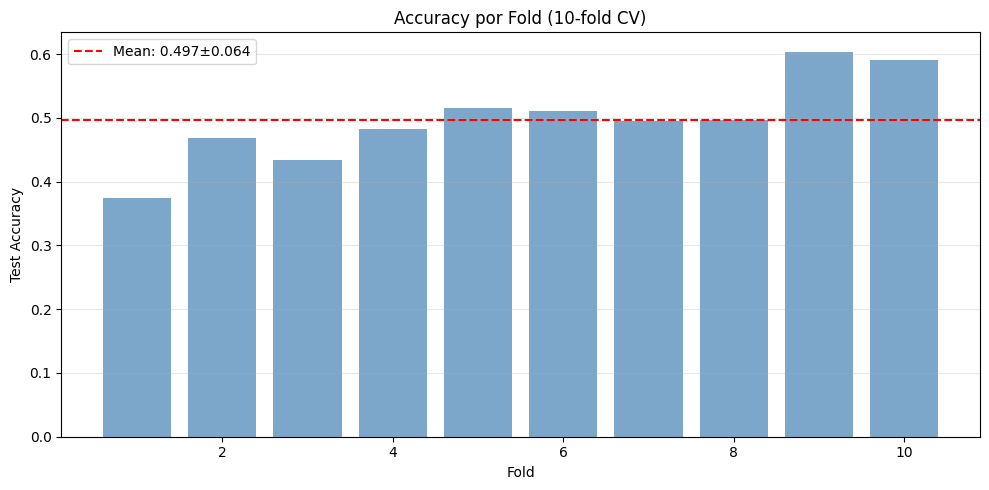

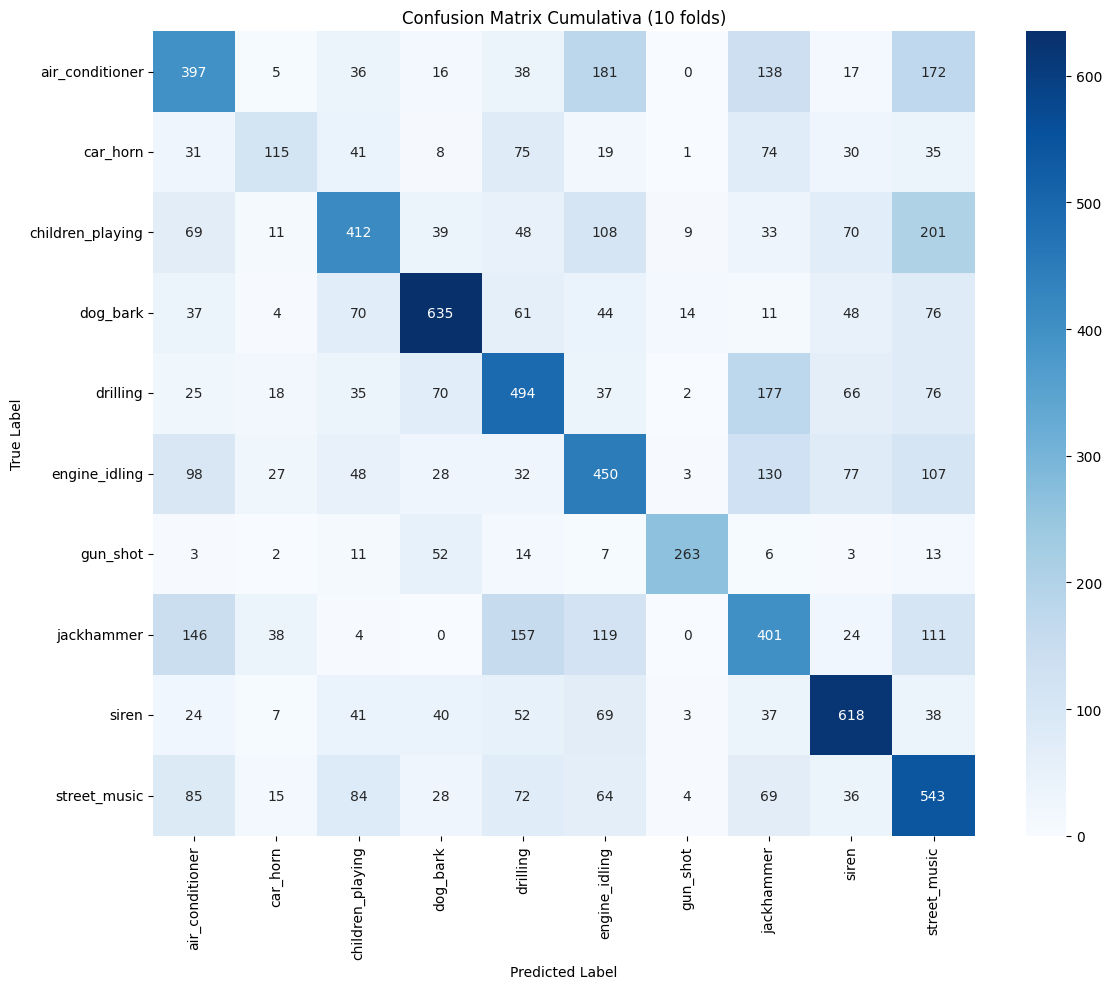

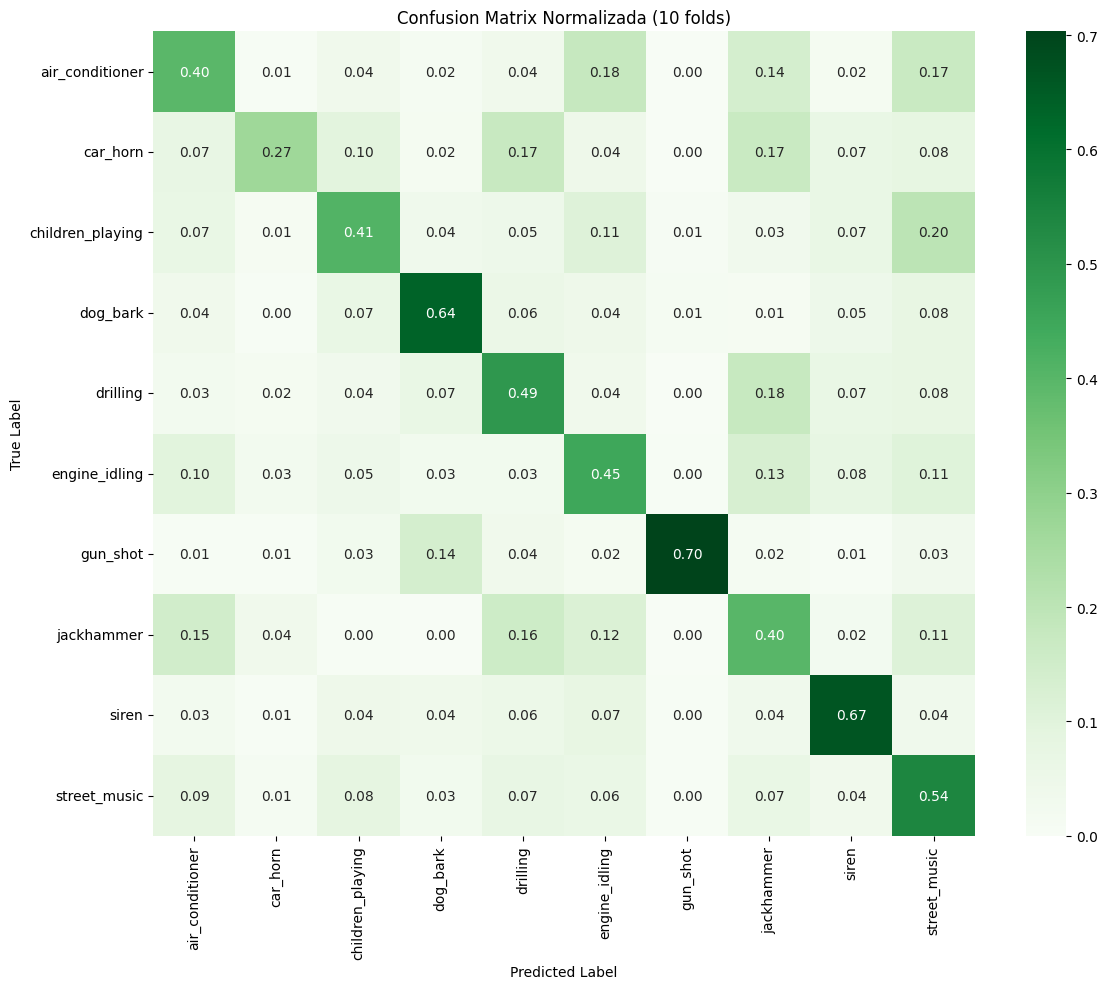

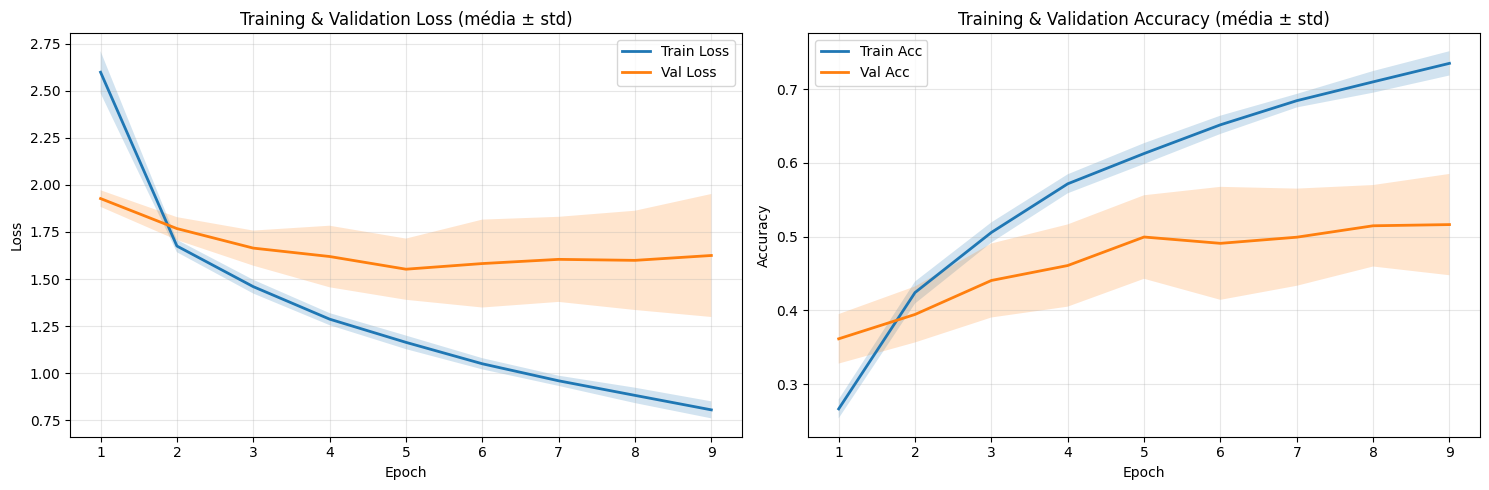


🔍 Debug: Confusion Matrix shape: (10, 10)
🔍 Debug: Total samples: 8732
🔍 Debug: Confusion Matrix:
[[397   5  36  16  38 181   0 138  17 172]
 [ 31 115  41   8  75  19   1  74  30  35]
 [ 69  11 412  39  48 108   9  33  70 201]
 [ 37   4  70 635  61  44  14  11  48  76]
 [ 25  18  35  70 494  37   2 177  66  76]
 [ 98  27  48  28  32 450   3 130  77 107]
 [  3   2  11  52  14   7 263   6   3  13]
 [146  38   4   0 157 119   0 401  24 111]
 [ 24   7  41  40  52  69   3  37 618  38]
 [ 85  15  84  28  72  64   4  69  36 543]]

Class 0 (air_conditioner): TP=397, FP=518, FN=603, P=0.434, R=0.397, F1=0.415
Class 1 (car_horn): TP=115, FP=127, FN=314, P=0.475, R=0.268, F1=0.343
Class 2 (children_playing): TP=412, FP=370, FN=588, P=0.527, R=0.412, F1=0.462
Class 3 (dog_bark): TP=635, FP=281, FN=365, P=0.693, R=0.635, F1=0.663
Class 4 (drilling): TP=494, FP=549, FN=506, P=0.474, R=0.494, F1=0.484
Class 5 (engine_idling): TP=450, FP=648, FN=550, P=0.410, R=0.450, F1=0.429
Class 6 (gun_shot): TP=

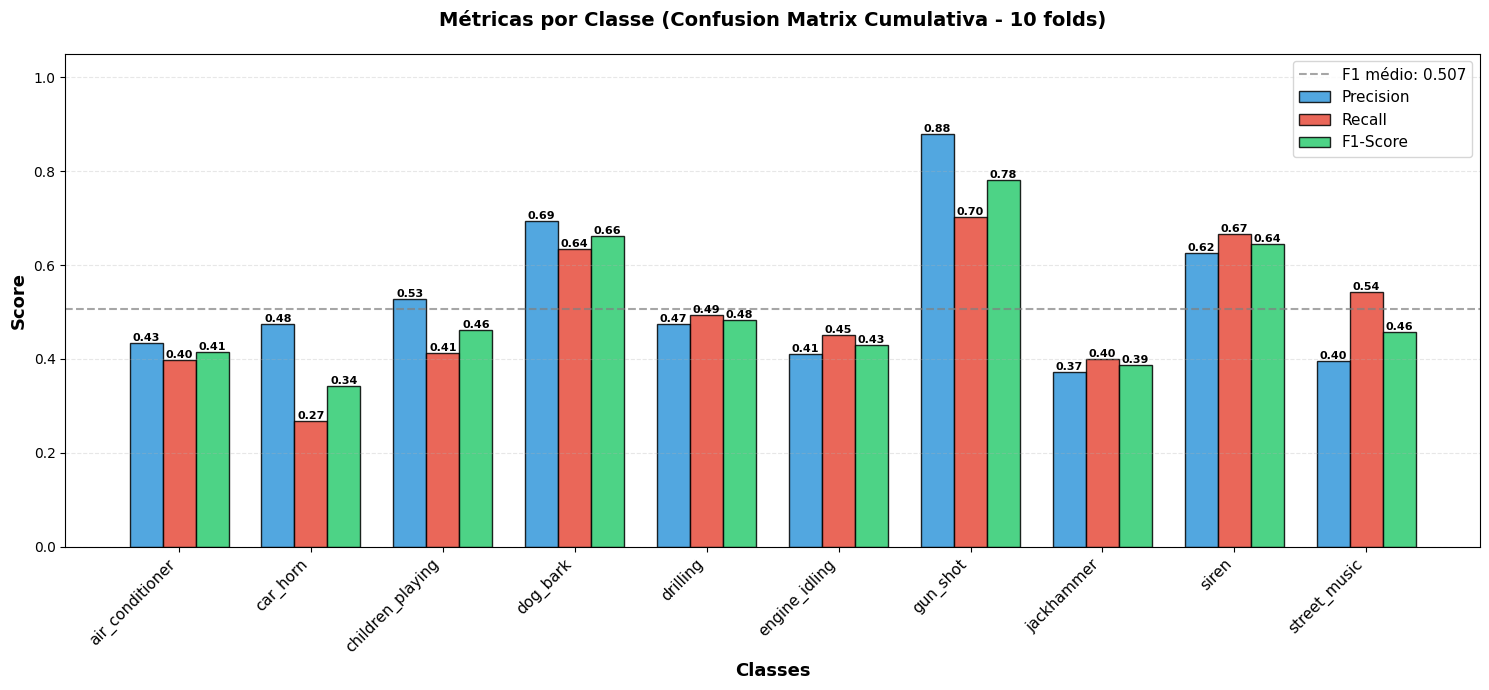


Class                Precision    Recall       F1-Score     Support      Accuracy    
air_conditioner      0.4339       0.3970       0.4146       1000         0.3970      
car_horn             0.4752       0.2681       0.3428       429          0.2681      
children_playing     0.5269       0.4120       0.4624       1000         0.4120      
dog_bark             0.6932       0.6350       0.6628       1000         0.6350      
drilling             0.4736       0.4940       0.4836       1000         0.4940      
engine_idling        0.4098       0.4500       0.4290       1000         0.4500      
gun_shot             0.8796       0.7032       0.7816       374          0.7032      
jackhammer           0.3727       0.4010       0.3863       1000         0.4010      
siren                0.6249       0.6652       0.6444       929          0.6652      
street_music         0.3958       0.5430       0.4578       1000         0.5430      
-----------------------------------------------------

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==== APÓS CORRER OS 10 FOLDS ====

# 1. Accuracy por fold
def plot_fold_accuracies(all_results):
    folds = [r['test_fold'] for r in all_results]
    accs = [r['test_acc'] for r in all_results]
    
    plt.figure(figsize=(10, 5))
    plt.bar(folds, accs, color='steelblue', alpha=0.7)
    plt.axhline(y=np.mean(accs), color='red', linestyle='--', 
                label=f'Mean: {np.mean(accs):.3f}±{np.std(accs):.3f}')
    plt.xlabel('Fold')
    plt.ylabel('Test Accuracy')
    plt.title('Accuracy por Fold (10-fold CV)')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('fold_accuracies.png', dpi=300)
    plt.show()

# 2. Confusion Matrix Cumulativa
def plot_cumulative_confusion_matrix(all_results, class_names):
    cm_cumulative = sum([r['confusion_matrix'] for r in all_results])
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_cumulative, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix Cumulativa (10 folds)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_cumulative.png', dpi=300)
    plt.show()
    
    # Normalizada (%)
    cm_norm = cm_cumulative.astype('float') / cm_cumulative.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix Normalizada (10 folds)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_normalized.png', dpi=300)
    plt.show()

# 3. Training curves (média dos folds)
def plot_average_training_curves(all_results):
    # Encontra o mínimo de epochs entre todos os folds
    min_epochs = min([len(r['history']['loss']) for r in all_results])
    
    # Trunca todas as histories para o mínimo
    train_losses = np.array([r['history']['loss'][:min_epochs] for r in all_results])
    val_losses = np.array([r['history']['val_loss'][:min_epochs] for r in all_results])
    train_accs = np.array([r['history']['accuracy'][:min_epochs] for r in all_results])
    val_accs = np.array([r['history']['val_accuracy'][:min_epochs] for r in all_results])
    
    epochs = range(1, min_epochs + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    ax1.plot(epochs, train_losses.mean(axis=0), label='Train Loss', linewidth=2)
    ax1.fill_between(epochs, 
                     train_losses.mean(axis=0) - train_losses.std(axis=0),
                     train_losses.mean(axis=0) + train_losses.std(axis=0),
                     alpha=0.2)
    ax1.plot(epochs, val_losses.mean(axis=0), label='Val Loss', linewidth=2)
    ax1.fill_between(epochs,
                     val_losses.mean(axis=0) - val_losses.std(axis=0),
                     val_losses.mean(axis=0) + val_losses.std(axis=0),
                     alpha=0.2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training & Validation Loss (média ± std)')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Accuracy
    ax2.plot(epochs, train_accs.mean(axis=0), label='Train Acc', linewidth=2)
    ax2.fill_between(epochs,
                     train_accs.mean(axis=0) - train_accs.std(axis=0),
                     train_accs.mean(axis=0) + train_accs.std(axis=0),
                     alpha=0.2)
    ax2.plot(epochs, val_accs.mean(axis=0), label='Val Acc', linewidth=2)
    ax2.fill_between(epochs,
                     val_accs.mean(axis=0) - val_accs.std(axis=0),
                     val_accs.mean(axis=0) + val_accs.std(axis=0),
                     alpha=0.2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training & Validation Accuracy (média ± std)')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300)
    plt.show()

from sklearn.metrics import classification_report

# 4. Métricas por classe (VERSÃO CORRIGIDA)
def plot_per_class_metrics_from_cm(all_results_mfcc, class_names):
    """Versão CORRIGIDA que calcula métricas a partir da confusion matrix cumulativa"""
    num_classes = len(class_names)
    
    # Somar todas as confusion matrices
    cm_cumulative = np.zeros((num_classes, num_classes), dtype=int)
    
    for r in all_results_mfcc:
        if 'confusion_matrix' in r:
            cm_cumulative += r['confusion_matrix']
        else:
            print(f"⚠️ Aviso: Fold {r.get('test_fold', '?')} não tem confusion_matrix")
    
    print(f"\n🔍 Debug: Confusion Matrix shape: {cm_cumulative.shape}")
    print(f"🔍 Debug: Total samples: {cm_cumulative.sum()}")
    print(f"🔍 Debug: Confusion Matrix:\n{cm_cumulative}\n")
    
    # Calcular métricas por classe
    precision_per_class = np.zeros(num_classes)
    recall_per_class = np.zeros(num_classes)
    f1_per_class = np.zeros(num_classes)
    support_per_class = np.zeros(num_classes)
    
    for i in range(num_classes):
        # True Positives: diagonal
        tp = cm_cumulative[i, i]
        
        # False Positives: soma da coluna i (exceto diagonal)
        fp = cm_cumulative[:, i].sum() - tp
        
        # False Negatives: soma da linha i (exceto diagonal)
        fn = cm_cumulative[i, :].sum() - tp
        
        # Support (total de samples desta classe)
        support_per_class[i] = cm_cumulative[i, :].sum()
        
        # Calcular métricas
        precision_per_class[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_per_class[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # F1-Score
        if precision_per_class[i] + recall_per_class[i] > 0:
            f1_per_class[i] = 2 * (precision_per_class[i] * recall_per_class[i]) / \
                                  (precision_per_class[i] + recall_per_class[i])
        else:
            f1_per_class[i] = 0
        
        print(f"Class {i} ({class_names[i]}): TP={tp}, FP={fp}, FN={fn}, "
              f"P={precision_per_class[i]:.3f}, R={recall_per_class[i]:.3f}, "
              f"F1={f1_per_class[i]:.3f}")
    
    # Verificar se há dados
    if cm_cumulative.sum() == 0:
        print("\n❌ ERRO: Confusion matrix vazia! Verifica os dados.")
        return
    
    # Plot
    x = np.arange(num_classes)
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(15, 7))
    bars1 = ax.bar(x - width, precision_per_class, width, 
                   label='Precision', alpha=0.85, color='#3498db', edgecolor='black')
    bars2 = ax.bar(x, recall_per_class, width, 
                   label='Recall', alpha=0.85, color='#e74c3c', edgecolor='black')
    bars3 = ax.bar(x + width, f1_per_class, width, 
                   label='F1-Score', alpha=0.85, color='#2ecc71', edgecolor='black')
    
    # Adicionar valores em cima das barras
    def autolabel(bars, values):
        for bar, val in zip(bars, values):
            height = bar.get_height()
            if height > 0:  # só mostrar se houver valor
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{val:.2f}',
                       ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    autolabel(bars1, precision_per_class)
    autolabel(bars2, recall_per_class)
    autolabel(bars3, f1_per_class)
    
    ax.set_xlabel('Classes', fontsize=13, fontweight='bold')
    ax.set_ylabel('Score', fontsize=13, fontweight='bold')
    ax.set_title('Métricas por Classe (Confusion Matrix Cumulativa - 10 folds)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=11)
    ax.legend(fontsize=12, loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    # Adicionar linha de média
    mean_f1 = np.mean(f1_per_class)
    ax.axhline(y=mean_f1, color='gray', linestyle='--', linewidth=1.5, 
               alpha=0.7, label=f'F1 médio: {mean_f1:.3f}')
    ax.legend(fontsize=11, loc='upper right')
    
    plt.tight_layout()
    plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Printar tabela detalhada
    print("\n" + "="*100)
    print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12} {'Accuracy':<12}")
    print("="*100)
    
    for i in range(num_classes):
        # Class accuracy = TP / Total da classe
        class_acc = cm_cumulative[i, i] / support_per_class[i] if support_per_class[i] > 0 else 0
        
        print(f"{class_names[i]:<20} "
              f"{precision_per_class[i]:<12.4f} "
              f"{recall_per_class[i]:<12.4f} "
              f"{f1_per_class[i]:<12.4f} "
              f"{int(support_per_class[i]):<12} "
              f"{class_acc:<12.4f}")
    
    print("-"*100)
    print(f"{'Macro Average':<20} "
          f"{np.mean(precision_per_class):<12.4f} "
          f"{np.mean(recall_per_class):<12.4f} "
          f"{np.mean(f1_per_class):<12.4f} "
          f"{int(support_per_class.sum()):<12} "
          f"{cm_cumulative.trace() / cm_cumulative.sum():<12.4f}")
    
    print(f"{'Weighted Average':<20} "
          f"{np.average(precision_per_class, weights=support_per_class):<12.4f} "
          f"{np.average(recall_per_class, weights=support_per_class):<12.4f} "
          f"{np.average(f1_per_class, weights=support_per_class):<12.4f} "
          f"{int(support_per_class.sum()):<12} "
          f"-")
    print("="*100)
    
    # Identificar classes problemáticas
    print("\n ANÁLISE POR CLASSE:")
    print("-"*60)
    
    # Classes com melhor performance
    best_f1_idx = np.argmax(f1_per_class)
    print(f" Melhor classe: {class_names[best_f1_idx]} (F1={f1_per_class[best_f1_idx]:.4f})")
    
    # Classes com pior performance
    worst_f1_idx = np.argmin(f1_per_class)
    print(f"  Pior classe: {class_names[worst_f1_idx]} (F1={f1_per_class[worst_f1_idx]:.4f})")
    
    # Classes desbalanceadas (P vs R)
    imbalance = np.abs(precision_per_class - recall_per_class)
    most_imbalanced_idx = np.argmax(imbalance)
    print(f"  Classe mais desbalanceada: {class_names[most_imbalanced_idx]} "
          f"(P={precision_per_class[most_imbalanced_idx]:.3f}, "
          f"R={recall_per_class[most_imbalanced_idx]:.3f})")
    
    print("-"*60)

# 5. Tabela resumo
def print_summary_table(all_results):
    print("\n" + "="*70)
    print("RESUMO FINAL - CNN 2D (MFCCs)")
    print("="*70)
    
    accs = [r['test_acc'] for r in all_results]
    f1s = [r['f1_macro'] for r in all_results]
    precs = [r['precision_macro'] for r in all_results]
    recs = [r['recall_macro'] for r in all_results]
    
    print(f"Accuracy:  {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    print(f"F1-Macro:  {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
    print(f"Precision: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
    print(f"Recall:    {np.mean(recs):.4f} ± {np.std(recs):.4f}")
    print("="*70)

# USAR TUDO:
class_names = ['air_conditioner', 'car_horn', 'children_playing', 
               'dog_bark', 'drilling', 'engine_idling', 
               'gun_shot', 'jackhammer', 'siren', 'street_music']

plot_fold_accuracies(all_results_mfcc)
plot_cumulative_confusion_matrix(all_results_mfcc, class_names)
plot_average_training_curves(all_results_mfcc)
plot_per_class_metrics_from_cm(all_results_mfcc, class_names)
print_summary_table(all_results_mfcc)

# Repetir o 10-fold para CNN 2D Mel e CNN 1D Wave

## Função genérica: treinar um fold com qualquer X, y e modelo

In [ ]:
def train_one_fold_generic(
    test_fold,
    metadata,
    X,
    y,
    build_model_fn,
    num_classes=10,
    max_epochs=50,
    batch_size=32
):
    # escolher val_fold como o seguinte
    val_fold = test_fold + 1 if test_fold < 10 else 1
    
    idx_test = metadata[metadata['fold'] == test_fold].index.values
    idx_val = metadata[metadata['fold'] == val_fold].index.values
    idx_train = metadata[~metadata['fold'].isin([test_fold, val_fold])].index.values
    
    X_train, y_train = X[idx_train], y[idx_train]
    X_val,   y_val   = X[idx_val],   y[idx_val]
    X_test,  y_test  = X[idx_test],  y[idx_test]
    
    input_shape = X.shape[1:]
    model = build_model_fn(input_shape, num_classes=num_classes)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    y_proba = model.predict(X_test, verbose=0)
    y_pred  = np.argmax(y_proba, axis=1)
    
    f1_macro = f1_score(y_test, y_pred, average='macro')
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))
    
    results = {
        "test_fold": test_fold,
        "val_fold": val_fold,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "f1_macro": f1_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "confusion_matrix": cm,
        "history": history.history
    }
    
    return results


In [ ]:
print(f"X_mel shape: {X_mel.shape}")
print(f"X_mfcc shape: {X_mfcc.shape}")

X_mel shape: (8732, 173, 128, 1)
X_mfcc shape: (8732, 173, 13, 1)


# CORRER ISTO Q DEMORA PRA CARALHO

In [ ]:
all_results_mel = []

for test_fold in range(1, 11):
    print(f"\n=== MEL | Fold {test_fold} como teste ===")
    res = train_one_fold_generic(
        test_fold=test_fold,
        metadata=metadata,
        X=X_mel,
        y=y_mel,
        build_model_fn=build_cnn2d,
        num_classes=10,
        max_epochs=10,
        batch_size=32
    )
    print(f"Fold {test_fold} - Acc: {res['test_acc']:.4f} | F1: {res['f1_macro']:.4f}")
    all_results_mel.append(res)



=== MEL | Fold 1 como teste ===


KeyboardInterrupt: 

# ALternativa de codigo do claude para o mel espectograma

In [ ]:
#  TREINO CNN 2D - MEL SPECTROGRAM
# ========================================

print("\n" + "="*60)
print(" TREINANDO CNN 2D (MEL SPECTROGRAM) - 10-FOLD CV")
print("="*60)

all_results_mel = []

for test_fold in range(1, 11):
    print(f"\n=== MEL | Fold {test_fold} como teste ===")
    
    res = train_one_fold_generic(
        test_fold=test_fold,
        metadata=metadata,
        X=X_mel,
        y=y_mel,
        build_model_fn=build_cnn2d,
        num_classes=10,
        max_epochs=50,
        batch_size=32
    )
    
    print(f"Fold {test_fold} - Acc: {res['test_acc']:.4f} | "
          f"F1: {res['f1_macro']:.4f} | "
          f"P: {res['precision_macro']:.4f} | "
          f"R: {res['recall_macro']:.4f}")
    
    all_results_mel.append(res)

# Resumo
accs = [r['test_acc'] for r in all_results_mel]
f1s = [r['f1_macro'] for r in all_results_mel]
print(f"\n CNN 2D MEL - Final:")
print(f"   Accuracy:  {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"   F1-Score:  {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

# Depois de correr um dos codigos acima analise de resultados

In [ ]:
# ANÁLISES DE RESULTADOS - CNN 2D MEL
# ========================================

print("\n" + "="*70)
print(" ANÁLISES CNN 2D MEL SPECTROGRAM")
print("="*70)

# 1. Accuracy por fold
plot_fold_accuracies(all_results_mel)

# 2. Confusion Matrix Cumulativa
plot_cumulative_confusion_matrix(all_results_mel, class_names)

# 3. Training curves médias
plot_average_training_curves(all_results_mel)

# 4. Métricas por classe
plot_per_class_metrics_from_cm(all_results_mel, class_names)

# 5. Tabela resumo
print_summary_table(all_results_mel)



Para já que hiperparâmetros temos ? 

- EarlyStopping (Isto evita overfitting, pára antes, mas não otimiza hiperparâmetros)

EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

- ReduceLROnPlateau (Isto muda dinamicamente o learning rate, mas não estás a escolher entre vários valores)

ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

- Arquitetura com Dropout

- batch_size = 32, max_epochs = 50, learning_rate = 1e-3

Para já temos os hiperparâmetros fixos e surge uma necessidade de fazer tuning e de testar diferentes learning rates, tamanhos de batch...



# TREINO DA CNN 1D

In [ ]:
#  TREINO CNN 1D - WAVEFORM


print("\n" + "="*60)
print(" TREINANDO CNN 1D (WAVEFORM) - 10-FOLD CV")
print("="*60)

all_results_wave = []

for test_fold in range(1, 11):
    print(f"\n=== WAVE | Fold {test_fold} como teste ===")
    
    res = train_one_fold_generic(
        test_fold=test_fold,
        metadata=metadata,
        X=X_wave,
        y=y_wave,
        build_model_fn=build_cnn1d_wave,
        num_classes=10,
        max_epochs=10,
        batch_size=32
    )
    
    print(f"Fold {test_fold} - Acc: {res['test_acc']:.4f} | "
          f"F1: {res['f1_macro']:.4f} | "
          f"P: {res['precision_macro']:.4f} | "
          f"R: {res['recall_macro']:.4f}")
    
    all_results_wave.append(res)

# Resumo
accs = [r['test_acc'] for r in all_results_wave]
f1s = [r['f1_macro'] for r in all_results_wave]
print(f"\n CNN 1D WAVEFORM - Final:")
print(f"   Accuracy:  {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"   F1-Score:  {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")



 TREINANDO CNN 1D (WAVEFORM) - 10-FOLD CV

=== WAVE | Fold 1 como teste ===


KeyboardInterrupt: 

# Análise de resultados da CNN 1D

In [ ]:
#  ANÁLISES DE RESULTADOS - CNN 1D WAVE
# ========================================

class_names = ['air_conditioner', 'car_horn', 'children_playing', 
               'dog_bark', 'drilling', 'engine_idling', 
               'gun_shot', 'jackhammer', 'siren', 'street_music']

print("\n" + "="*70)
print(" ANÁLISES CNN 1D WAVEFORM")
print("="*70)

# 1. Accuracy por fold
plot_fold_accuracies(all_results_wave)

# 2. Confusion Matrix Cumulativa
plot_cumulative_confusion_matrix(all_results_wave, class_names)

# 3. Training curves médias
plot_average_training_curves(all_results_wave)

# 4. Métricas por classe
plot_per_class_metrics_from_cm(all_results_wave, class_names)

# 5. Tabela resumo
print_summary_table(all_results_wave)